# <font color=blue>WWU CS Mentors Machine Learning Workshop</font>
#### _By Robin Cosbey and Josh Myers-Dean_

## What we will accomplish in this excersize 
- Learn how to read in a CSV and do some exploratory data analysis
- Build a decision tree model from scratch
- Use our model to predict // TODO WORD THIS BETTER

### Exploratory Data Analysis
First we will read in a csv file containing information about different species of iris flowers

In [4]:
'''
Pandas is a great library for data manipulation and visualizations,
here we read in the csv and represent it as a dataframe (df). I like to think
of these as fancy dictionaries.
'''

import pandas as pd
df = pd.read_csv("iris.csv")
df.head() # allows us to peak at the first 5 rows of data

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Our data has 4 different features we can use and seem to be labelled by what class of iris they are. <br />
Now that we've got a sneak peek of our data, let's try and see what else we can find out about it before we move on to our model!

In [9]:
print("Dataframe Shape: ", df.shape,"\n")
print("Summary Statistics:\n\n", df.describe())

Dataframe Shape:  (150, 5) 

Summary Statistics:

        sepal-length  sepal-width  petal-length  petal-width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000


Awesome! So now we have some useful information about the dataset we are working with. We can think of our dataset as a 150x5 matrix, or simply view it as a CSV with 150 entries with each entry having 5 features.
<br /> 
<br />
The summary statistics give us a view into how the data is distributed, let's take a more visual look at our data.

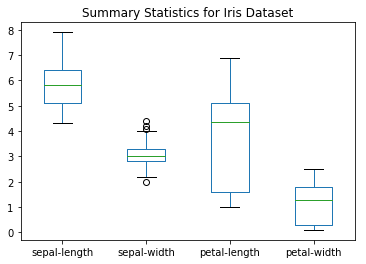

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
ax = df.boxplot(grid=False)
ax.set_title("Summary Statistics for Iris Dataset")
plt.show()

You can get pretty creative in your EDA visualizations, but for now we will create a simple boxplot showing our summary statistics using the library matplotlib.

TODO 

In [11]:
import numpy as np


class Node:
    def __init__(self, left, right, rule):
        self.left = left
        self.right = right
        self.feature = rule[0]
        self.threshold = rule[1]


class Leaf:
    def __init__(self, value):
        """
        `value` is an array of class probabilities if classifier is True, else
        the mean of the region
        """
        self.value = value


class DecisionTree:
    def __init__(
        self,
        classifier=True,
        max_depth=None,
        n_feats=None,
        criterion="entropy",
        seed=None,
    ):
        """
        A decision tree model for regression and classification problems.
        Parameters
        ----------
        classifier : bool
            Whether to treat target values as categorical (classifier =
            True) or continuous (classifier = False). Default is True.
        max_depth: int or None
            The depth at which to stop growing the tree. If None, grow the tree
            until all leaves are pure. Default is None.
        n_feats : int
            Specifies the number of features to sample on each split. If None,
            use all features on each split. Default is None.
        criterion : {'mse', 'entropy', 'gini'}
            The error criterion to use when calculating splits. When
            `classifier` is False, valid entries are {'mse'}. When `classifier`
            is True, valid entries are {'entropy', 'gini'}. Default is
            'entropy'.
        seed : int or None
            Seed for the random number generator. Default is None.
        """
        if seed:
            np.random.seed(seed)

        self.depth = 0
        self.root = None

        self.n_feats = n_feats
        self.criterion = criterion
        self.classifier = classifier
        self.max_depth = max_depth if max_depth else np.inf

        if not classifier and criterion in ["gini", "entropy"]:
            raise ValueError(
                "{} is a valid criterion only when classifier = True.".format(criterion)
            )
        if classifier and criterion == "mse":
            raise ValueError("`mse` is a valid criterion only when classifier = False.")

    def fit(self, X, Y):
        """
        Fit a binary decision tree to a dataset.
        Parameters
        ----------
        X : :py:class:`ndarray <numpy.ndarray>` of shape `(N, M)`
            The training data of `N` examples, each with `M` features
        Y : :py:class:`ndarray <numpy.ndarray>` of shape `(N,)`
            An array of integer class labels for each example in `X` if
            self.classifier = True, otherwise the set of target values for
            each example in `X`.
        """
        self.n_classes = max(Y) + 1 if self.classifier else None
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow(X, Y)

    def predict(self, X):
        """
        Use the trained decision tree to classify or predict the examples in `X`.
        Parameters
        ----------
        X : :py:class:`ndarray <numpy.ndarray>` of shape `(N, M)`
            The training data of `N` examples, each with `M` features
        Returns
        -------
        preds : :py:class:`ndarray <numpy.ndarray>` of shape `(N,)`
            The integer class labels predicted for each example in `X` if
            self.classifier = True, otherwise the predicted target values.
        """
        return np.array([self._traverse(x, self.root) for x in X])

    def predict_class_probs(self, X):
        """
        Use the trained decision tree to return the class probabilities for the
        examples in `X`.
        Parameters
        ----------
        X : :py:class:`ndarray <numpy.ndarray>` of shape `(N, M)`
            The training data of `N` examples, each with `M` features
        Returns
        -------
        preds : :py:class:`ndarray <numpy.ndarray>` of shape `(N, n_classes)`
            The class probabilities predicted for each example in `X`.
        """
        assert self.classifier, "`predict_class_probs` undefined for classifier = False"
        return np.array([self._traverse(x, self.root, prob=True) for x in X])

    def _grow(self, X, Y):
        # if all labels are the same, return a leaf
        if len(set(Y)) == 1:
            if self.classifier:
                prob = np.zeros(self.n_classes)
                prob[Y[0]] = 1.0
            return Leaf(prob) if self.classifier else Leaf(Y[0])

        # if we have reached max_depth, return a leaf
        if self.depth >= self.max_depth:
            v = np.mean(Y, axis=0)
            if self.classifier:
                v = np.bincount(Y, minlength=self.n_classes) / len(Y)
            return Leaf(v)

        N, M = X.shape
        self.depth += 1
        feat_idxs = np.random.choice(M, self.n_feats, replace=False)

        # greedily select the best split according to `criterion`
        feat, thresh = self._segment(X, Y, feat_idxs)
        l = np.argwhere(X[:, feat] <= thresh).flatten()
        r = np.argwhere(X[:, feat] > thresh).flatten()

        # grow the children that result from the split
        left = self._grow(X[l, :], Y[l])
        right = self._grow(X[r, :], Y[r])
        return Node(left, right, (feat, thresh))

    def _segment(self, X, Y, feat_idxs):
        """
        Find the optimal split rule (feature index and split threshold) for the
        data according to `self.criterion`.
        """
        best_gain = -np.inf
        split_idx, split_thresh = None, None
        for i in feat_idxs:
            vals = X[:, i]
            levels = np.unique(vals)
            thresholds = (levels[:-1] + levels[1:]) / 2 if len(levels) > 1 else levels
            gains = np.array([self._impurity_gain(Y, t, vals) for t in thresholds])

            if gains.max() > best_gain:
                split_idx = i
                best_gain = gains.max()
                split_thresh = thresholds[gains.argmax()]

        return split_idx, split_thresh

    def _impurity_gain(self, Y, split_thresh, feat_values):
        """
        Compute the impurity gain associated with a given split.
        IG(split) = loss(parent) - weighted_avg[loss(left_child), loss(right_child)]
        """
        if self.criterion == "entropy":
            loss = entropy
        elif self.criterion == "gini":
            loss = gini
        elif self.criterion == "mse":
            loss = mse

        parent_loss = loss(Y)

        # generate split
        left = np.argwhere(feat_values <= split_thresh).flatten()
        right = np.argwhere(feat_values > split_thresh).flatten()

        if len(left) == 0 or len(right) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(Y)
        n_l, n_r = len(left), len(right)
        e_l, e_r = loss(Y[left]), loss(Y[right])
        child_loss = (n_l / n) * e_l + (n_r / n) * e_r

        # impurity gain is difference in loss before vs. after split
        ig = parent_loss - child_loss
        return ig

    def _traverse(self, X, node, prob=False):
        if isinstance(node, Leaf):
            if self.classifier:
                return node.value if prob else node.value.argmax()
            return node.value
        if X[node.feature] <= node.threshold:
            return self._traverse(X, node.left, prob)
        return self._traverse(X, node.right, prob)


def mse(y):
    """
    Mean squared error for decision tree (ie., mean) predictions
    """
    return np.mean((y - np.mean(y)) ** 2)


def entropy(y):
    """
    Entropy of a label sequence
    """
    hist = np.bincount(y)
    ps = hist / np.sum(hist)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])


def gini(y):
    """
    Gini impurity (local entropy) of a label sequence
    """
    hist = np.bincount(y)
    N = np.sum(hist)
    return 1 - sum([(i / N) ** 2 for i in hist])

In [12]:
dt = DecisionTree()

In [13]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
iris = datasets.load_iris()
x = iris.data
y = iris.target
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.5)
dt.fit(x_train, y_train)

In [14]:
predictions=lr.predict(dt_test)
predictions

array([2, 1, 2, 2, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 2, 2, 1, 0, 2, 0, 0, 0,
       0, 2, 1, 2, 2, 1, 0, 1, 0, 1, 2, 1, 1, 1, 2, 1, 2, 0, 0, 2, 0, 1,
       0, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0,
       0, 2, 0, 0, 1, 2, 1, 1, 2])

In [15]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,predictions))

0.9466666666666667
